In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import statsmodels.formula.api as smf

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler
from lightgbm import LGBMClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import StratifiedKFold,KFold
from sklearn.model_selection import cross_val_score

import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import roc_auc_score,accuracy_score,f1_score,log_loss

plt.rcParams["font.sans-serif"]=["SimHei"]#正常显示中文
plt.rcParams["axes.unicode_minus"]=False#正常显示负号

from jupyterthemes import jtplot
jtplot.style(theme='onedork') #选择一个绘图主题

train=pd.read_csv('G://classStudy/II 2/机器学习/大作业/贷款违约预测/train.csv')
test=pd.read_csv('G://classStudy/II 2/机器学习/大作业/贷款违约预测/testA.csv')

In [2]:
train.head()

,id,loanAmnt,term,interestRate,installment,grade,subGrade,employmentTitle,employmentLength,homeOwnership,...,n5,n6,n7,n8,n9,n10,n11,n12,n13,n14
0,0,35000.0,5,19.52,917.97,E,E2,320.0,2 years,2,...,9.0,8.0,4.0,12.0,2.0,7.0,0.0,0.0,0.0,2.0
1,1,18000.0,5,18.49,461.90,D,D2,219843.0,5 years,0,...,NaN,NaN,NaN,NaN,NaN,13.0,NaN,NaN,NaN,NaN
2,2,12000.0,5,16.99,298.17,D,D3,31698.0,8 years,0,...,0.0,21.0,4.0,5.0,3.0,11.0,0.0,0.0,0.0,4.0
3,3,11000.0,3,7.26,340.96,A,A4,46854.0,10+ years,1,...,16.0,4.0,7.0,21.0,6.0,9.0,0.0,0.0,0.0,1.0
4,4,3000.0,3,12.99,101.07,C,C2,54.0,NaN,1,...,4.0,9.0,10.0,15.0,7.0,12.0,0.0,0.0,0.0,4.0


In [3]:
train.shape

(800000, 47)

In [4]:
test.shape

(200000, 46)

In [5]:
train.columns

Index(['id', 'loanAmnt', 'term', 'interestRate', 'installment', 'grade',
       'subGrade', 'employmentTitle', 'employmentLength', 'homeOwnership',
       'annualIncome', 'verificationStatus', 'issueDate', 'isDefault',
       'purpose', 'postCode', 'regionCode', 'dti', 'delinquency_2years',
       'ficoRangeLow', 'ficoRangeHigh', 'openAcc', 'pubRec',
       'pubRecBankruptcies', 'revolBal', 'revolUtil', 'totalAcc',
       'initialListStatus', 'applicationType', 'earliesCreditLine', 'title',
       'policyCode', 'n0', 'n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7', 'n8',
       'n9', 'n10', 'n11', 'n12', 'n13', 'n14'],
      dtype='object')

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800000 entries, 0 to 799999
Data columns (total 47 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   id                  800000 non-null  int64  
 1   loanAmnt            800000 non-null  float64
 2   term                800000 non-null  int64  
 3   interestRate        800000 non-null  float64
 4   installment         800000 non-null  float64
 5   grade               800000 non-null  object 
 6   subGrade            800000 non-null  object 
 7   employmentTitle     799999 non-null  float64
 8   employmentLength    753201 non-null  object 
 9   homeOwnership       800000 non-null  int64  
 10  annualIncome        800000 non-null  float64
 11  verificationStatus  800000 non-null  int64  
 12  issueDate           800000 non-null  object 
 13  isDefault           800000 non-null  int64  
 14  purpose             800000 non-null  int64  
 15  postCode            799999 non-nul

In [7]:
train.describe()

,id,loanAmnt,term,interestRate,installment,employmentTitle,homeOwnership,annualIncome,verificationStatus,isDefault,...,n5,n6,n7,n8,n9,n10,n11,n12,n13,n14
count,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,799999.000000,800000.000000,8.000000e+05,800000.000000,800000.000000,...,759730.000000,759730.000000,759730.000000,759729.000000,759730.000000,766761.000000,730248.000000,759730.000000,759730.000000,759730.000000
mean,399999.500000,14416.818875,3.482745,13.238391,437.947723,72005.351714,0.614213,7.613391e+04,1.009683,0.199513,...,8.107937,8.575994,8.282953,14.622488,5.592345,11.643896,0.000815,0.003384,0.089366,2.178606
std,230940.252015,8716.086178,0.855832,4.765757,261.460393,106585.640204,0.675749,6.894751e+04,0.782716,0.399634,...,4.799210,7.400536,4.561689,8.124610,3.216184,5.484104,0.030075,0.062041,0.509069,1.844377
min,0.000000,500.000000,3.000000,5.310000,15.690000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,199999.750000,8000.000000,3.000000,9.750000,248.450000,427.000000,0.000000,4.560000e+04,0.000000,0.000000,...,5.000000,4.000000,5.000000,9.000000,3.000000,8.000000,0.000000,0.000000,0.000000,1.000000
50%,399999.500000,12000.000000,3.000000,12.740000,375.135000,7755.000000,1.000000,6.500000e+04,1.000000,0.000000,...,7.000000,7.000000,7.000000,13.000000,5.000000,11.000000,0.000000,0.000000,0.000000,2.000000
75%,599999.250000,20000.000000,3.000000,15.990000,580.710000,117663.500000,1.000000,9.000000e+04,2.000000,0.000000,...,11.000000,11.000000,10.000000,19.000000,7.000000,14.000000,0.000000,0.000000,0.000000,3.000000
max,799999.000000,40000.000000,5.000000,30.990000,1715.420000,378351.000000,5.000000,1.099920e+07,2.000000,1.000000,...,70.000000,132.000000,79.000000,128.000000,45.000000,82.000000,4.000000,4.000000,39.000000,30.000000


In [8]:
# 数值类型
numerical_feature = list(train.select_dtypes(exclude=['object']).columns)
numerical_feature

['id',
 'loanAmnt',
 'term',
 'interestRate',
 'installment',
 'employmentTitle',
 'homeOwnership',
 'annualIncome',
 'verificationStatus',
 'isDefault',
 'purpose',
 'postCode',
 'regionCode',
 'dti',
 'delinquency_2years',
 'ficoRangeLow',
 'ficoRangeHigh',
 'openAcc',
 'pubRec',
 'pubRecBankruptcies',
 'revolBal',
 'revolUtil',
 'totalAcc',
 'initialListStatus',
 'applicationType',
 'title',
 'policyCode',
 'n0',
 'n1',
 'n2',
 'n3',
 'n4',
 'n5',
 'n6',
 'n7',
 'n8',
 'n9',
 'n10',
 'n11',
 'n12',
 'n13',
 'n14']

In [9]:
len(numerical_feature)

42

In [10]:
# 连续型变量
serial_feature = []
# 离散型变量
discrete_feature = []
# 单值变量
unique_feature = []

for fea in numerical_feature:
    temp = train[fea].nunique()# 返回的是唯一值的个数
    if temp == 1:
        unique_feature.append(fea)
     # 自定义变量的值的取值个数小于10就为离散型变量    
    elif temp <= 10:
        discrete_feature.append(fea)
    else:
        serial_feature.append(fea)

In [11]:
serial_feature

['id',
 'loanAmnt',
 'interestRate',
 'installment',
 'employmentTitle',
 'annualIncome',
 'purpose',
 'postCode',
 'regionCode',
 'dti',
 'delinquency_2years',
 'ficoRangeLow',
 'ficoRangeHigh',
 'openAcc',
 'pubRec',
 'pubRecBankruptcies',
 'revolBal',
 'revolUtil',
 'totalAcc',
 'title',
 'n0',
 'n1',
 'n2',
 'n3',
 'n4',
 'n5',
 'n6',
 'n7',
 'n8',
 'n9',
 'n10',
 'n13',
 'n14']

Text(0.5, 0, 'loanAmnt')

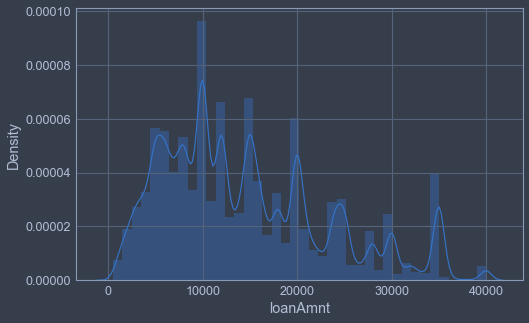

In [12]:
plt.figure(1 , figsize = (8 , 5))
sns.distplot(train.loanAmnt,bins=40)
plt.xlabel('loanAmnt')

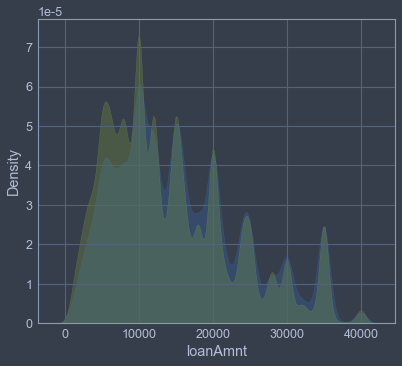

In [13]:
label=train.isDefault             
label.value_counts()/len(label)

sns.kdeplot(train.loanAmnt[label[label==1].index], label='1', shade=True)#违约
sns.kdeplot(train.loanAmnt[label[label==0].index], label='0', shade=True)#没有违约
plt.xlabel('loanAmnt')
plt.ylabel('Density');

Text(0.5, 0, 'annualIncome')

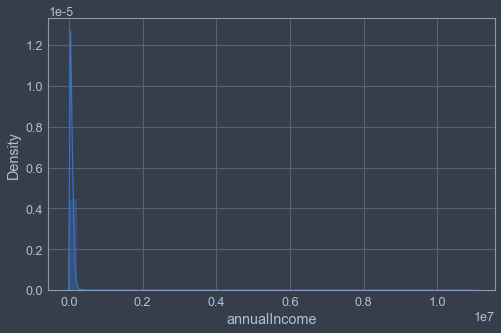

In [14]:
plt.figure(1 , figsize = (8 , 5))
sns.distplot(train['annualIncome'])
plt.xlabel('annualIncome')

In [15]:
discrete_feature

['term',
 'homeOwnership',
 'verificationStatus',
 'isDefault',
 'initialListStatus',
 'applicationType',
 'n11',
 'n12']

In [16]:
for f in discrete_feature:
    print(f, '类型数：', train[f].nunique())

term 类型数： 2
homeOwnership 类型数： 6
verificationStatus 类型数： 3
isDefault 类型数： 2
initialListStatus 类型数： 2
applicationType 类型数： 2
n11 类型数： 5
n12 类型数： 5


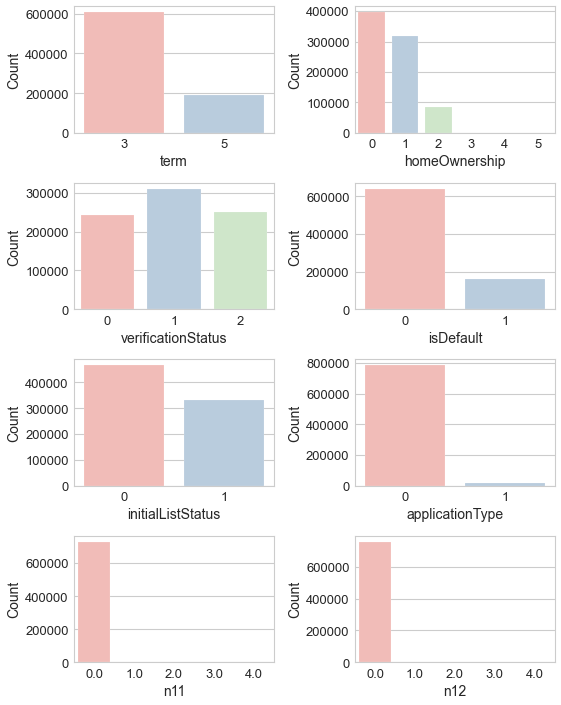

In [17]:
df_ = train[discrete_feature]

sns.set_style("whitegrid") # 使用whitegrid主题
fig,axes=plt.subplots(nrows=4,ncols=2,figsize=(8,10))
for i, item in enumerate(df_):
    plt.subplot(4,2,(i+1))
    #ax=df[item].value_counts().plot(kind = 'bar')
    ax=sns.countplot(item,data = df_,palette="Pastel1")
    plt.xlabel(str(item),fontsize=14)   
    plt.ylabel('Count',fontsize=14)
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
    #plt.title("Churn by "+ str(item))
    i=i+1
    plt.tight_layout()
plt.show()

In [18]:
unique_feature

['policyCode']

In [19]:
# 分类型特征
category_feature = list(filter(lambda x: x not in numerical_feature,list(train.columns)))
category_feature

['grade', 'subGrade', 'employmentLength', 'issueDate', 'earliesCreditLine']

In [20]:
train[category_feature]

,grade,subGrade,employmentLength,issueDate,earliesCreditLine
0,E,E2,2 years,2014-07-01,Aug-2001
1,D,D2,5 years,2012-08-01,May-2002
2,D,D3,8 years,2015-10-01,May-2006
3,A,A4,10+ years,2015-08-01,May-1999
4,C,C2,NaN,2016-03-01,Aug-1977
...,...,...,...,...,...
799995,C,C4,7 years,2016-07-01,Aug-2011
799996,A,A4,10+ years,2013-04-01,May-1989
799997,C,C3,10+ years,2015-10-01,Jul-2002
799998,A,A4,10+ years,2015-02-01,Jan-1994


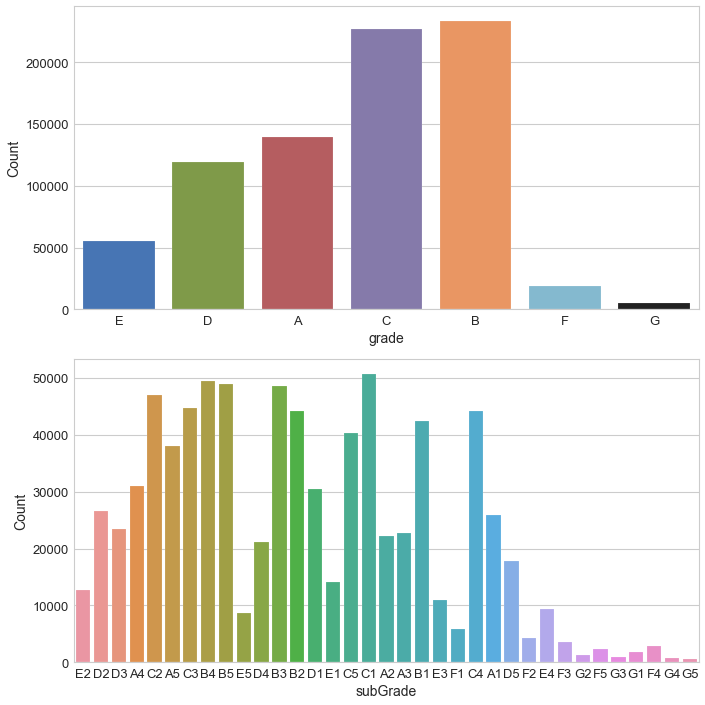

In [21]:
df_category = train[['grade', 'subGrade']]

sns.set_style("whitegrid") # 使用whitegrid主题
color = sns.color_palette()
fig,axes=plt.subplots(nrows=2,ncols=1,figsize=(10,10))
for i, item in enumerate(df_category):
    plt.subplot(2,1,(i+1))
    #ax=df[item].value_counts().plot(kind = 'bar')
    ax=sns.countplot(item,data = df_category)
    plt.xlabel(str(item),fontsize=14)   
    plt.ylabel('Count',fontsize=14)
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
    #plt.title("Churn by "+ str(item))
    i=i+1
    plt.tight_layout()
plt.show()

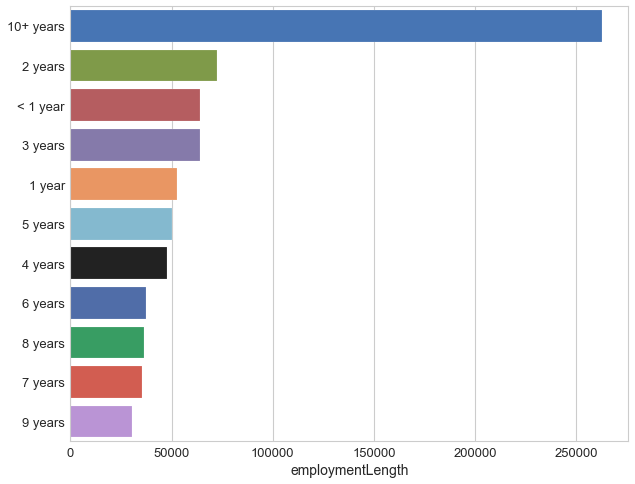

In [22]:
plt.figure(1 , figsize = (10 , 8))
sns.barplot(train["employmentLength"].value_counts(dropna=False),
            train["employmentLength"].value_counts(dropna=False).keys())
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xlabel('employmentLength',fontsize=14)   
plt.show()

In [23]:
for i in train[['issueDate', 'earliesCreditLine']]:
    print(train[i].value_counts())
    print()

2016-03-01    29066
2015-10-01    25525
2015-07-01    24496
2015-12-01    23245
2014-10-01    21461
              ...  
2007-08-01       23
2007-07-01       21
2008-09-01       19
2007-09-01        7
2007-06-01        1
Name: issueDate, Length: 139, dtype: int64

Aug-2001    5567
Aug-2002    5403
Sep-2003    5403
Oct-2001    5258
Aug-2000    5246
            ... 
Oct-2015       1
Apr-1958       1
Jan-1944       1
Aug-1955       1
Dec-1951       1
Name: earliesCreditLine, Length: 720, dtype: int64



In [24]:
label=train.isDefault             
label.value_counts()/len(label)

0    0.800488
1    0.199513
Name: isDefault, dtype: float64

<AxesSubplot:xlabel='isDefault', ylabel='count'>

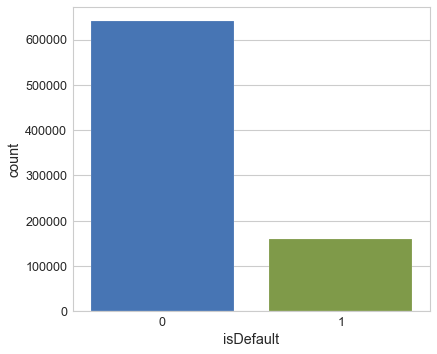

In [25]:
sns.countplot(label)

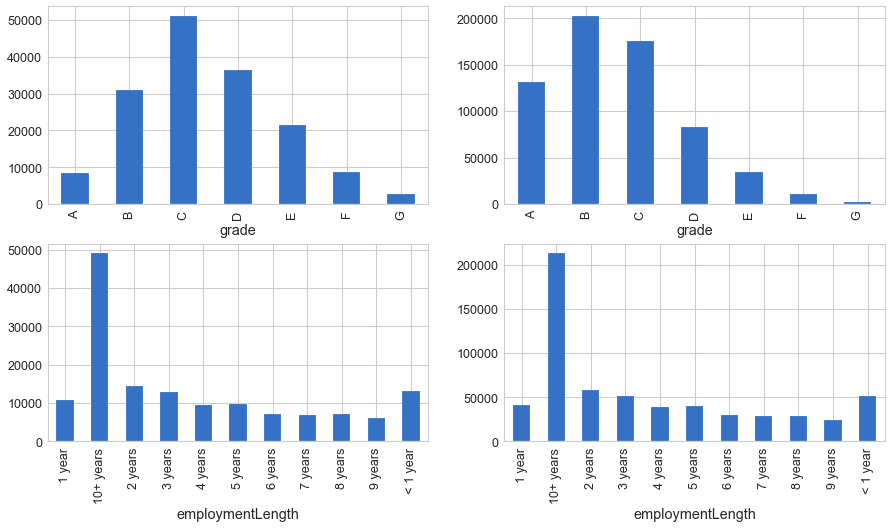

In [26]:
train_loan_fr = train.loc[train['isDefault'] == 1]
train_loan_nofr = train.loc[train['isDefault'] == 0]

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 8)) 
# 目标变量为1时候grade的分布
train_loan_fr.groupby("grade").size().plot.bar(ax=ax1)
# 目标变量为0时候grade的分布
train_loan_nofr.groupby("grade")["grade"].count().plot.bar(ax=ax2)
# 目标变量为1时候employmentLength的分布
train_loan_fr.groupby("employmentLength").size().plot.bar(ax=ax3)
# 目标变量为0时候employmentLength的分布
train_loan_nofr.groupby("employmentLength")["employmentLength"].count().plot.bar(ax=ax4)
plt.xticks(rotation=90);

In [27]:
train_positve = train[train['isDefault'] == 1]
train_negative = train[train['isDefault'] != 1]

In [28]:
# 去掉标签
X_missing = train.drop(['isDefault'],axis=1)

# 查看缺失情况
missing = X_missing.isna().sum()
missing = pd.DataFrame(data={'特征': missing.index,'缺失值个数':missing.values})
#通过~取反，选取不包含数字0的行
missing = missing[~missing['缺失值个数'].isin([0])]
# 缺失比例
missing['缺失比例'] =  missing['缺失值个数']/X_missing.shape[0]
missing

,特征,缺失值个数,缺失比例
7,employmentTitle,1,0.000001
8,employmentLength,46799,0.058499
14,postCode,1,0.000001
16,dti,239,0.000299
22,pubRecBankruptcies,405,0.000506
24,revolUtil,531,0.000664
29,title,1,0.000001
31,n0,40270,0.050338
32,n1,40270,0.050338
33,n2,40270,0.050338


<AxesSubplot:>

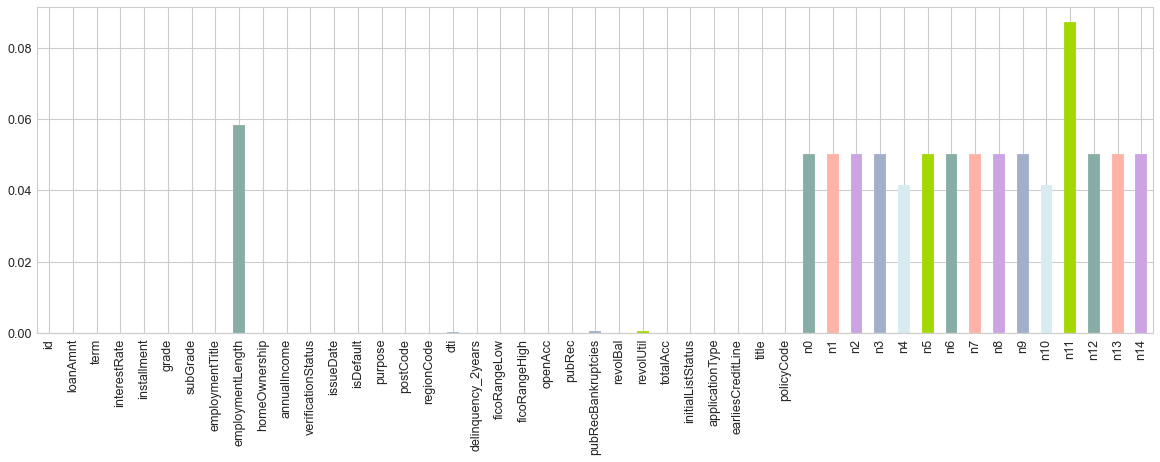

In [29]:
# 可视化
(train.isnull().sum()/len(train)).plot.bar(figsize = (20,6),color=['#d6ecf0','#a3d900','#88ada6','#ffb3a7','#cca4e3','#a1afc9'])

<AxesSubplot:>

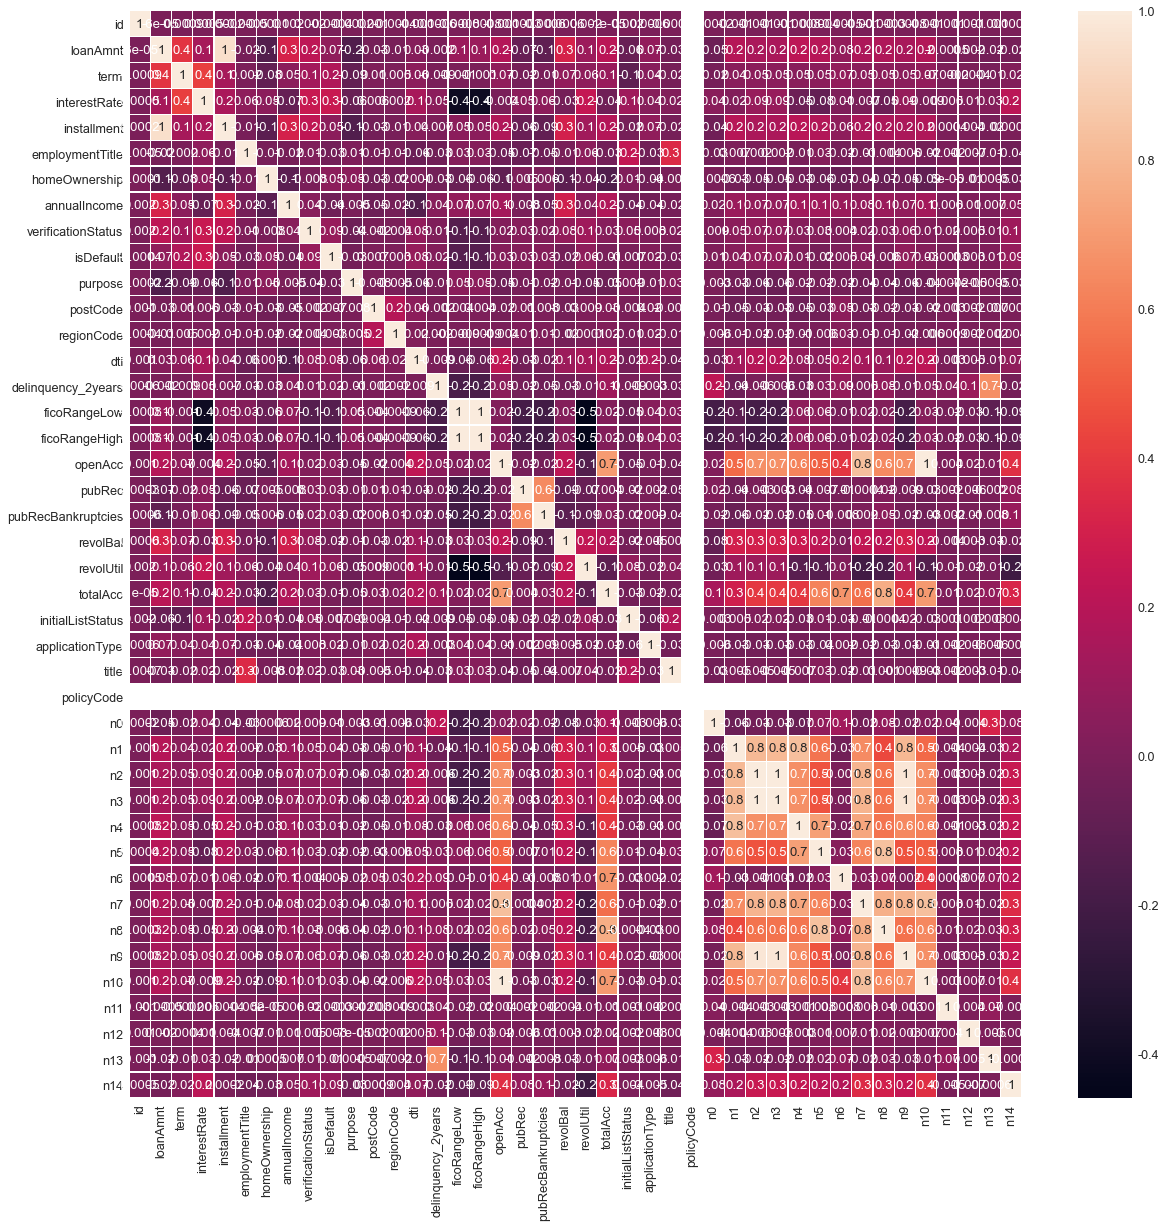

In [30]:
f, ax = plt.subplots(1,1, figsize = (20,20))
cor = train[numerical_feature].corr()
sns.heatmap(cor, annot = True, linewidth = 0.2, linecolor = "white", ax = ax, fmt =".1g" )

In [31]:
train.duplicated().sum()

0

In [32]:
label = 'isDefault'
Y_label = train['isDefault']
numerical_feature.remove(label)

In [33]:
# 训练集
train[numerical_feature] = train[numerical_feature].fillna(train[numerical_feature].median())
# 测试集
test[numerical_feature] = test[numerical_feature].fillna(train[numerical_feature].median())

In [34]:
train[category_feature]

,grade,subGrade,employmentLength,issueDate,earliesCreditLine
0,E,E2,2 years,2014-07-01,Aug-2001
1,D,D2,5 years,2012-08-01,May-2002
2,D,D3,8 years,2015-10-01,May-2006
3,A,A4,10+ years,2015-08-01,May-1999
4,C,C2,NaN,2016-03-01,Aug-1977
...,...,...,...,...,...
799995,C,C4,7 years,2016-07-01,Aug-2011
799996,A,A4,10+ years,2013-04-01,May-1989
799997,C,C3,10+ years,2015-10-01,Jul-2002
799998,A,A4,10+ years,2015-02-01,Jan-1994


In [35]:
# 训练集
train[category_feature] = train[category_feature].fillna(train[category_feature].mode())
# 测试集
test[category_feature] = test[category_feature].fillna(train[category_feature].mode())

In [36]:
train.isnull().sum()

id                        0
loanAmnt                  0
term                      0
interestRate              0
installment               0
grade                     0
subGrade                  0
employmentTitle           0
employmentLength      46799
homeOwnership             0
annualIncome              0
verificationStatus        0
issueDate                 0
isDefault                 0
purpose                   0
postCode                  0
regionCode                0
dti                       0
delinquency_2years        0
ficoRangeLow              0
ficoRangeHigh             0
openAcc                   0
pubRec                    0
pubRecBankruptcies        0
revolBal                  0
revolUtil                 0
totalAcc                  0
initialListStatus         0
applicationType           0
earliesCreditLine         0
title                     0
policyCode                0
n0                        0
n1                        0
n2                        0
n3                  

In [37]:
train.employmentLength

0           2 years
1           5 years
2           8 years
3         10+ years
4               NaN
            ...    
799995      7 years
799996    10+ years
799997    10+ years
799998    10+ years
799999      5 years
Name: employmentLength, Length: 800000, dtype: object

In [38]:
from sklearn.tree import DecisionTreeClassifier

empLenNotNullInd = train.employmentLength.notnull() # 不是空的行，返回True
columns = ['postCode','regionCode','employmentTitle','annualIncome'] # 用四个特征来预测employmentLength
train_empLen_X  = train.loc[empLenNotNullInd,columns]
train_empLen_y = train.employmentLength[empLenNotNullInd]

DTC = DecisionTreeClassifier() # 实例化
DTC.fit(train_empLen_X ,train_empLen_y) # 训练
print(DTC.score(train_empLen_X ,train_empLen_y))

0.9809320486828881


In [39]:
# 预测
for data in [train,test]:
    empLenIsNullInd = data.employmentLength.isnull()
    test_empLen_X  = data.loc[empLenIsNullInd,columns]
    empLen_pred = DTC.predict(test_empLen_X)
    data.employmentLength[empLenIsNullInd] = empLen_pred

In [40]:
train.isnull().any().sum()

0

In [41]:
train['employmentLength'][:20]

0       2 years
1       5 years
2       8 years
3     10+ years
4       5 years
5       7 years
6       9 years
7        1 year
8       5 years
9       6 years
10    10+ years
11      3 years
12      2 years
13    10+ years
14      2 years
15      2 years
16      9 years
17     < 1 year
18    10+ years
19      9 years
Name: employmentLength, dtype: object

In [42]:
train['employmentLength'].value_counts(dropna=False).sort_index()

1 year        55208
10+ years    276957
2 years       76492
3 years       68977
4 years       50984
5 years       53865
6 years       39512
7 years       37120
8 years       37950
9 years       31372
< 1 year      71563
Name: employmentLength, dtype: int64

In [43]:
def find_outliers_by_3segama(data,fea):
    data_std = np.std(data[fea])
    data_mean = np.mean(data[fea])
    outliers_cut_off = data_std * 3
    lower_rule = data_mean - outliers_cut_off
    upper_rule = data_mean + outliers_cut_off
    data[fea+'_outliers'] = data[fea].apply(lambda x:str('异常值') if x > upper_rule or x < lower_rule else '正常值')
    return data

In [44]:
data_train = train.copy()
for fea in numerical_feature:
    data_train = find_outliers_by_3segama(data_train,fea)
    print(data_train[fea+'_outliers'].value_counts())
    print(data_train.groupby(fea+'_outliers')['isDefault'].sum())
    print('*'*10)

正常值    800000
Name: id_outliers, dtype: int64
id_outliers
正常值    159610
Name: isDefault, dtype: int64
**********
正常值    800000
Name: loanAmnt_outliers, dtype: int64
loanAmnt_outliers
正常值    159610
Name: isDefault, dtype: int64
**********
正常值    800000
Name: term_outliers, dtype: int64
term_outliers
正常值    159610
Name: isDefault, dtype: int64
**********
正常值    794259
异常值      5741
Name: interestRate_outliers, dtype: int64
interestRate_outliers
异常值      2916
正常值    156694
Name: isDefault, dtype: int64
**********
正常值    792046
异常值      7954
Name: installment_outliers, dtype: int64
installment_outliers
异常值      2152
正常值    157458
Name: isDefault, dtype: int64
**********
正常值    800000
Name: employmentTitle_outliers, dtype: int64
employmentTitle_outliers
正常值    159610
Name: isDefault, dtype: int64
**********
正常值    799701
异常值       299
Name: homeOwnership_outliers, dtype: int64
homeOwnership_outliers
异常值        62
正常值    159548
Name: isDefault, dtype: int64
**********
正常值    793973
异常值      

In [45]:
train['issueDate']

0         2014-07-01
1         2012-08-01
2         2015-10-01
3         2015-08-01
4         2016-03-01
             ...    
799995    2016-07-01
799996    2013-04-01
799997    2015-10-01
799998    2015-02-01
799999    2018-08-01
Name: issueDate, Length: 800000, dtype: object

In [46]:
train.shape

(800000, 47)

In [47]:
import datetime
# 转化成时间格式 issueDateDT特征表示数据日期离数据集中日期最早的日期（2007-06-01）的天数
train['issueDate'] = pd.to_datetime(train['issueDate'],format='%Y-%m-%d')
startdate = datetime.datetime.strptime('2007-06-01', '%Y-%m-%d')
train['issueDateDT'] = train['issueDate'].apply(lambda x: x-startdate).dt.days

train.shape 

(800000, 48)

In [48]:
train[['issueDate','issueDateDT']]

,issueDate,issueDateDT
0,2014-07-01,2587
1,2012-08-01,1888
2,2015-10-01,3044
3,2015-08-01,2983
4,2016-03-01,3196
...,...,...
799995,2016-07-01,3318
799996,2013-04-01,2131
799997,2015-10-01,3044
799998,2015-02-01,2802


In [49]:
#转化成时间格式
test['issueDate'] = pd.to_datetime(train['issueDate'],format='%Y-%m-%d')
startdate = datetime.datetime.strptime('2007-06-01', '%Y-%m-%d')
test['issueDateDT'] = test['issueDate'].apply(lambda x: x-startdate).dt.days

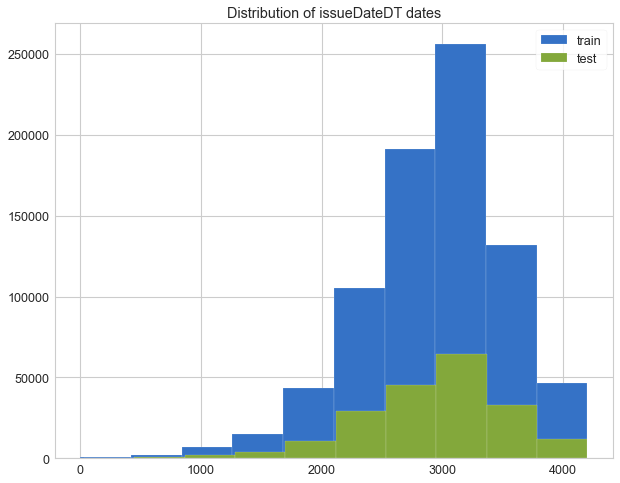

In [50]:
plt.figure(1 , figsize = (10 , 8))
plt.hist(train['issueDateDT'], label='train');
plt.hist(test['issueDateDT'], label='test');
plt.legend();
plt.title('Distribution of issueDateDT dates');
#train 和 test issueDateDT 日期有重叠 所以使用基于时间的分割进行验证是不明智的

In [51]:
train[['issueDate','earliesCreditLine']]

,issueDate,earliesCreditLine
0,2014-07-01,Aug-2001
1,2012-08-01,May-2002
2,2015-10-01,May-2006
3,2015-08-01,May-1999
4,2016-03-01,Aug-1977
...,...,...
799995,2016-07-01,Aug-2011
799996,2013-04-01,May-1989
799997,2015-10-01,Jul-2002
799998,2015-02-01,Jan-1994


In [52]:
train_earliesCreditLine_year = train['earliesCreditLine'].apply(lambda x:x[-4:]).astype('int64')
test_earliesCreditLine_year = test['earliesCreditLine'].apply(lambda x:x[-4:]).astype('int64')

train_issueDate_year = train['issueDate'].astype('str').apply(lambda x:x[:4]).astype('int64')
test_issueDate_year = test['issueDate'].astype('str').apply(lambda x:x[:4]).astype('int64')

train['CreditLine'] = train_issueDate_year - train_earliesCreditLine_year
test['CreditLine'] = test_issueDate_year - test_earliesCreditLine_year

train = train.drop(['earliesCreditLine','issueDate'],axis=1)
test = test.drop(['earliesCreditLine','issueDate'],axis=1)

In [53]:
train['CreditLine']

0         13
1         10
2          9
3         16
4         39
          ..
799995     5
799996    24
799997    13
799998    21
799999    16
Name: CreditLine, Length: 800000, dtype: int64

In [54]:
train.shape

(800000, 47)

In [55]:
def employmentLength_to_int(s):
    if pd.isnull(s):
        return s
    else:
        return np.int8(s.split()[0])
for data in [train, test]:
    data['employmentLength'].replace(to_replace='10+ years', value='10 years', inplace=True)
    data['employmentLength'].replace('< 1 year', '0 years', inplace=True)
    data['employmentLength'] = data['employmentLength'].apply(employmentLength_to_int)

In [56]:
train['employmentLength'][:20]

0      2
1      5
2      8
3     10
4      5
5      7
6      9
7      1
8      5
9      6
10    10
11     3
12     2
13    10
14     2
15     2
16     9
17     0
18    10
19     9
Name: employmentLength, dtype: int64

In [57]:
a2z = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
a2z_code = np.arange(1,27)
a2z_mapping = dict(zip(a2z, a2z_code))

for data in [train,test]:
    data.loc[:,['grade','subGrade']] = data.loc[:,['grade','subGrade']].applymap(lambda g:g.replace(g[0], str(a2z.index(g[0])+1))).astype('int')

In [58]:
train[['grade','subGrade']]

,grade,subGrade
0,5,52
1,4,42
2,4,43
3,1,14
4,3,32
...,...,...
799995,3,34
799996,1,14
799997,3,33
799998,1,14


In [59]:
train[['grade','subGrade']]

,grade,subGrade
0,5,52
1,4,42
2,4,43
3,1,14
4,3,32
...,...,...
799995,3,34
799996,1,14
799997,3,33
799998,1,14


In [60]:
train[['homeOwnership','verificationStatus','purpose']]

,homeOwnership,verificationStatus,purpose
0,2,2,1
1,0,2,0
2,0,2,0
3,1,1,4
4,1,2,10
...,...,...,...
799995,1,0,0
799996,0,2,4
799997,1,2,0
799998,0,2,4


In [61]:
train.shape

(800000, 47)

In [62]:
from sklearn.preprocessing import OneHotEncoder
oh = OneHotEncoder(sparse=False)
oh.fit(train[['homeOwnership','verificationStatus','purpose']])
OneHot1 = oh.transform(train[['homeOwnership','verificationStatus','purpose']])
OneHot2 = oh.transform(test[['homeOwnership','verificationStatus','purpose']])

OneHot1.shape

train = pd.concat([train, pd.DataFrame(OneHot1)], axis=1)
test = pd.concat([test, pd.DataFrame(OneHot2)], axis=1)

train = train.drop(['homeOwnership','verificationStatus','purpose'],axis=1)
test = test.drop(['homeOwnership','verificationStatus','purpose'],axis=1)

train.shape

(800000, 67)

In [63]:
train=train.drop(["id"],axis=1) 
train.shape

(800000, 66)

In [64]:
test=test.drop(["id"],axis=1) 
test.shape 

(200000, 65)

In [65]:
train.corr()["isDefault"].sort_values()

ficoRangeLow    -0.130994
ficoRangeHigh   -0.130993
6               -0.085972
0               -0.069264
annualIncome    -0.042782
                   ...   
interestRate     0.259202
grade            0.261858
subGrade         0.266415
isDefault        1.000000
policyCode            NaN
Name: isDefault, Length: 66, dtype: float64

In [66]:
train=train.drop(["initialListStatus","n5","n11","n12","n8","postCode","policyCode"],axis=1)
test=test.drop(["initialListStatus","n5","n11","n12","n8","postCode","policyCode"],axis=1)

train.shape

(800000, 59)

In [67]:
# 显示相关性高于0.6的变量
def getHighRelatedFeatureDf(corr_matrix, corr_threshold):
    highRelatedFeatureDf = pd.DataFrame(corr_matrix[corr_matrix>corr_threshold].stack().reset_index())
    highRelatedFeatureDf.rename({'level_0':'feature_x', 'level_1':'feature_y', 0:'corr'}, axis=1, inplace=True)
    highRelatedFeatureDf = highRelatedFeatureDf[highRelatedFeatureDf.feature_x != highRelatedFeatureDf.feature_y]
    highRelatedFeatureDf['feature_pair_key'] = highRelatedFeatureDf.loc[:,['feature_x', 'feature_y']].apply(lambda r:'#'.join(np.sort(r.values)), axis=1)
    highRelatedFeatureDf.drop_duplicates(subset=['feature_pair_key'],inplace=True)
    highRelatedFeatureDf.drop(['feature_pair_key'], axis=1, inplace=True)
    return highRelatedFeatureDf

getHighRelatedFeatureDf(train.corr(),0.6)

,feature_x,feature_y,corr
1,loanAmnt,installment,0.953369
4,interestRate,grade,0.953269
5,interestRate,subGrade,0.970847
10,grade,subGrade,0.993907
21,delinquency_2years,n13,0.653769
23,ficoRangeLow,ficoRangeHigh,1.000000
27,openAcc,totalAcc,0.700796
28,openAcc,n2,0.648589
29,openAcc,n3,0.648589
30,openAcc,n4,0.611362


In [68]:
col = ['installment','ficoRangeHigh','openAcc','n3','n9']
for data in [train,test]:
    data.drop(col,axis=1,inplace=True)

In [69]:
train.shape

(800000, 54)

In [70]:
train.var().sort_values()

4                     4.124835e-05
5                     1.012399e-04
3                     2.311968e-04
22                    2.374439e-04
20                    6.920213e-04
21                    1.700849e-03
15                    5.412886e-03
16                    6.671150e-03
19                    7.015095e-03
17                    1.070416e-02
10                    1.125295e-02
18                    1.141417e-02
applicationType       1.889629e-02
12                    2.149093e-02
14                    5.449902e-02
11                    6.091534e-02
2                     9.624693e-02
pubRecBankruptcies    1.424212e-01
isDefault             1.597075e-01
13                    1.712028e-01
6                     2.106089e-01
8                     2.143586e-01
7                     2.372906e-01
1                     2.394067e-01
9                     2.435811e-01
n13                   2.464878e-01
0                     2.499719e-01
pubRec                3.678020e-01
term                

In [71]:
col = ['applicationType']
for data in [train,test]:
    data.drop(col,axis=1,inplace=True)

In [72]:
train.shape 

(800000, 53)

In [86]:
train.columns

Index([          'loanAmnt',               'term',       'interestRate',
                    'grade',           'subGrade',    'employmentTitle',
         'employmentLength',       'annualIncome',          'isDefault',
               'regionCode',                'dti', 'delinquency_2years',
             'ficoRangeLow',             'pubRec', 'pubRecBankruptcies',
                 'revolBal',          'revolUtil',           'totalAcc',
                    'title',                 'n0',                 'n1',
                       'n2',                 'n4',                 'n6',
                       'n7',                'n10',                'n13',
                      'n14',        'issueDateDT',         'CreditLine',
                          0,                    1,                    2,
                          3,                    4,                    5,
                          6,                    7,                    8,
                          9,                   10, 

In [87]:
tags = ['loanAmnt', 'term', 'interestRate', 'grade',
       'subGrade', 'employmentTitle', 'employmentLength',
       'annualIncome','regionCode', 'dti', 'delinquency_2years',
       'ficoRangeLow', 'pubRec',
       'pubRecBankruptcies', 'revolBal', 'revolUtil', 'totalAcc','title',
       'n0', 'n1', 'n2', 'n4',  'n6', 'n7',
       'n10', 'n13', 'n14','issueDateDT','CreditLine',0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22]

In [88]:
from sklearn.preprocessing import StandardScaler
Standard_scaler = StandardScaler()
Standard_scaler.fit(train[tags].values)
x = Standard_scaler.transform(train[tags].values)
x_ = Standard_scaler.transform(test[tags].values)
y = train['isDefault'].values

In [89]:
lgbr = LGBMRegressor(num_leaves=30,
                        max_depth=10,
                        learning_rate=0.01,
                        n_estimators=13000,
                        subsample_for_bin=5000,
                        min_child_samples=200,
                        colsample_bytree=0.2,
                        reg_alpha=0.1,
                        reg_lambda=0.1,
                        seed=2020,                   
                        )

In [90]:
cat = CatBoostRegressor(depth=9, 
                            l2_leaf_reg=1, 
                            learning_rate=0.01, 
                            eval_metric = 'AUC' ,
                            border_count = 128, 
                            bagging_temperature = 0.9 , 
                            n_estimators=16000,
                            early_stopping_rounds=500, 
                            subsample = 0.9,
                            random_seed=1,
                            verbose = 0)

In [91]:
from sklearn.ensemble import VotingRegressor

rg_model = VotingRegressor([('lgb', lgbr), ('catboost', cat)],n_jobs=12)

In [92]:
rg_model.fit(x,y)
pre = pd.DataFrame(rg_model.predict(x_),columns=['isDefault'])

KeyError: 'id'

In [93]:
sample_submit=pd.read_csv('G://classStudy/II 2/机器学习/大作业/贷款违约预测/sample_submit.csv')
results = pd.concat([sample_submit['id'],pre],axis = 1)
results.to_csv('submit.csv', index=False)

In [94]:
results

,id,isDefault
0,800000,0.074277
1,800001,0.284672
2,800002,0.604182
3,800003,0.340205
4,800004,0.293478
...,...,...
199995,999995,0.176773
199996,999996,0.066420
199997,999997,0.232597
199998,999998,0.232586
